<font size="10">Learning Transformations to Period-Doubling Normal Forms with the Centre Manifold Theorem</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a change of variable from the nonlinear mapping of Golden and Ydstie (1988, Systems and Control Letters). We combine centre manifold and normal form theory to target a transformation to a system in three variables 
$(y_1,y_2,y_3)$, for which $y_1$ represents the dynamics on the centre manifold and $(y_2,y_3)$ are on the stable manifold. We focus our computations about a point of (supercritical) period-doubling bifurcation in the map and so the dynamics of $y_1$ are governed by the normal form of this bifurcation: $g_{\mathrm{pd}}(y,\nu) = - y - y(\nu - y^2)$. The stable components $(y_2,y_3)$ are governed by a linear matrix equation for which the matrix is given by the Jordan normal form of the linearization of the stable components at the bifurcation point.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.3 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

In [28]:
# Sample random points in the (x,mu) domain
N = 5000 # number of samples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xn = 0.4*torch.rand(N,4, dtype=torch.float32).to(device) - 0.2 # Augmented to include the 3D state x_n and 1D parameter mu (Randomly generated)
xnp1 = torch.zeros(N,4, dtype=torch.float32).to(device)

# Forward iterate of the adaptive control map
xnp1[:,0] = xn[:,1]
xnp1[:,1] = (xn[:,3]*0.1 + 0.25) * (xn[:,0] + 1) + (xn[:,1] + 1) * ( xn[:,2] - xn[:,3]*0.1 - 0.25)
xnp1[:,2] = xn[:,2] - ((xn[:,3]*0.1 + 0.25) * (xn[:,0] + 1) * (xn[:,1] + 1)) - (xn[:,2] - xn[:,3]*0.1 - 0.25) * (xn[:,1] + 1) * (xn[:,1] + 1)
xnp1[:,3] = xn[:,3]

In [45]:
# Conjugacy neural network architecture

class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 4,
                 size_y = 4,
                 activation = nn.SELU(),
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.numblksIn = numblksIn
        self.numblksOut = numblksOut
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        # Final layer to go to logistic map variables
        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function
        decoder_layers = [nn.Linear(self.size_y, self.width), self.activation]
        for _ in range(self.numblksOut-1):  # adding more layers
            decoder_layers.append(nn.Linear(self.width, self.width))
            decoder_layers.append(self.activation)

        # Final layer to go to tent map variables
        decoder_layers.append(nn.Linear(self.width, size_x))
        decoder_layers.append(self.activation)
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias=0
            nn.init.normal_(module.weight, mean=0.0, std=0.1)
            nn.init.zeros_(module.bias)

    def forward(self, x, xmx=0):
        encoded = self.encoder(x)

        # Build forward iterates under normal form
        ynp1 = -encoded[:,0] - encoded[:,3]*encoded[:,0] + torch.square(encoded[:,0])*encoded[:,0] # Period-doubling normal form
        ynp2 = 0.5*(math.cos(0.7227)*encoded[:,1] + math.sin(0.7227)*encoded[:,2])
        ynp3 = 0.5*(-math.sin(0.7227)*encoded[:,1] + math.cos(0.7227)*encoded[:,2])
        munp1 = encoded[:,3] # parameter step
        encoded_p1 = torch.stack([ynp1, ynp2, ynp3, munp1], dim=1)
        decoded = self.decoder(encoded_p1)

        # Encoder/Decoder loss
        x_recon = self.decoder(encoded)
        conjugacy_loss = torch.mean(torch.square(x[0] - x_recon))

        # f = rho of g of eta loss
        xnp1_1 = x[:,1]
        xnp1_2 = (x[:,3]*0.1 + 0.25) * (x[:,0] + 1) + (x[:,1] + 1) * (x[:,2] - x[:,3]*0.1 - 0.25)
        xnp1_3 = x[:,2] - (x[:,3]*0.1 + 0.25) * (x[:,0] + 1) * (x[:,1] + 1) - (x[:,2] - x[:,3]*0.1 - 0.25) * (x[:,1] + 1) * (x[:,1] + 1)
        xnp1_4 = x[:,3]
        xnp1 = torch.stack([xnp1_1, xnp1_2, xnp1_3, xnp1_4], dim=1)
        prediction_loss = torch.mean(torch.square(decoded - xnp1))

        # Normal form loss
        xnp1_encoded = self.encoder(xnp1)
        normal_form_loss = torch.mean(torch.square(encoded_p1 - xnp1_encoded))

        # Enforce bifurcation point
        bf_pt_loss = torch.mean(torch.square(self.encoder(0*x)))

        # # L1L2 Regularization loss
        L1L2_loss = sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        L1L2_loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        total_loss = conjugacy_loss + prediction_loss + normal_form_loss + L1L2_loss + bf_pt_loss

        return decoded, total_loss

In [47]:
width = 200 # width of each NN layer
size_x = 4 # number of variables in the adaptive control map (states + parameters)
size_y = 4 # number of variables in the normal form (states + parameters)
activation = nn.SELU() # nonlinear activation function at each NN layer
learning_rate = 0.00005
numblks_in = 3 # number of layers for the encoder NN
numblks_out = 3 # number of layers for the decoder NN

conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out).to(device)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

In [48]:
def train(model, optimizer, epochs=10, patience=500):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        min_loss = float('inf')
        optimizer.zero_grad()
        decoded,loss = model(xn)

        loss.backward()
        optimizer.step()

        min_loss = min(min_loss, loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {min_loss}")

        if min_loss < best_loss:
            best_loss = min_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train(conjugacy, optimizer, epochs=10000)

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.00059610849712044
Epoch 5002/10000, Loss: 0.0005940942792221904
Epoch 5003/10000, Loss: 0.0005913294153288007
Epoch 5004/10000, Loss: 0.0005887529696337879
Epoch 5005/10000, Loss: 0.0005870504537597299
Epoch 5006/10000, Loss: 0.0005865942221134901
Epoch 5007/10000, Loss: 0.0005871238536201417
Epoch 5008/10000, Loss: 0.0005881238030269742
Epoch 5009/10000, Loss: 0.0005890707834623754
Epoch 5010/10000, Loss: 0.0005894864443689585
Epoch 5011/10000, Loss: 0.000589336734265089
Epoch 5012/10000, Loss: 0.0005884809070266783
Epoch 5013/10000, Loss: 0.0005872941692359746
Epoch 5014/10000, Loss: 0.0005859186057932675
Epoch 5015/10000, Loss: 0.0005849046283401549
Epoch 5016/10000, Loss: 0.0005843828548677266
Epoch 5017/10000, Loss: 0.0005843400140292943
Epoch 5018/10000, Loss: 0.000584702065680176
Epoch 5019/10000, Loss: 0.0005852935719303787
Epoch 5020/10000, Loss: 0.0005860069650225341
Epoch 5021/10000, Loss: 0.0005866

tensor([[ 0.1749,  0.0316, -0.2237,  0.4846],
        [ 0.1749,  0.0316, -0.2237,  0.4845],
        [ 0.1749,  0.0316, -0.2236,  0.4845],
        ...,
        [ 0.3146,  0.0646, -0.1889, -0.5904],
        [ 0.3146,  0.0646, -0.1889, -0.5904],
        [ 0.3147,  0.0646, -0.1889, -0.5905]])


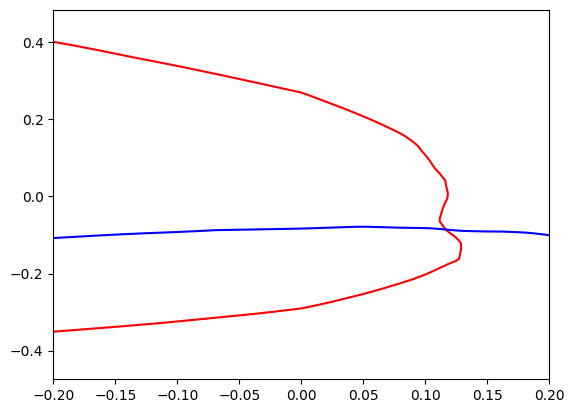

In [49]:
# Check where fixed points in the normal form go to
flip_1 = torch.zeros(10000,4, dtype=torch.float32) # first point of the 2-cycle in normal form
flip_2 = torch.zeros(10000,4, dtype=torch.float32) # second point of the 2-cycle in normal form
fixed_pt = torch.zeros(20000,4, dtype=torch.float32) # trivial fixed point in normal form
for n in range(10000):
    fixed_pt[n,3] = -0.2+0.2*n/10000
    fixed_pt[10000+n,3] = 0.2*n/10000
    flip_1[n,3] = 0.2*n/10000
    flip_2[n,3] = flip_1[n,3]
    flip_1[n,0] = torch.sqrt(flip_1[n,3])
    flip_2[n,0] = -torch.sqrt(flip_2[n,3])

# Decode normal form fixed points
flip_x1 = conjugacy.decoder(flip_1.to(device)).cpu().detach()
flip_x2 = conjugacy.decoder(flip_2.to(device)).cpu().detach()
fixed_pt_x = conjugacy.decoder(fixed_pt.to(device)).cpu().detach()

# Plot results
plt.plot(flip_x1[:,3],flip_x1[:,2],'r')
plt.plot(flip_x2[:,3],flip_x2[:,2],'r')
plt.plot(fixed_pt_x[:,3],fixed_pt_x[:,2],'b')
plt.xlim(-0.2,0.2);

# Print results
print(fixed_pt_x)

In [ ]:
# Loading the model
import tensorflow as tf

def loadModel(file_path, numblksIn=5, numblksOut=5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    tf_model = tf.keras.models.load_model(file_path)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(numblksIn=numblksIn, numblksOut=numblksOut).to(device)
    for i in range(numblksIn+1):
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    for i in range(numblksOut+1):
        pytorch_model.decoder[2*i].weight = nn.Parameter(conju_wt[2*(i+numblksIn+1)].T)
        pytorch_model.decoder[2*i].bias = nn.Parameter(conju_wt[2*(i+numblksIn+1)+1])

    return pytorch_model

conjugacy = loadModel( "../saved_conjugacy_networks/period_doubling")

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


tensor([[ 3.1842e-03,  8.5535e-03,  6.0223e-03, -3.7224e-01],
        [ 3.1835e-03,  8.5505e-03,  6.0199e-03, -3.7221e-01],
        [ 3.1828e-03,  8.5474e-03,  6.0174e-03, -3.7217e-01],
        ...,
        [ 4.3864e-05, -1.0698e-02,  5.2657e-03,  4.5020e-01],
        [ 4.4185e-05, -1.0699e-02,  5.2669e-03,  4.5024e-01],
        [ 4.4889e-05, -1.0701e-02,  5.2677e-03,  4.5028e-01]])


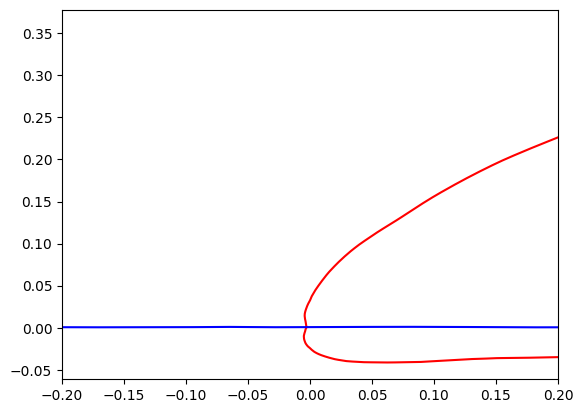

In [ ]:
# Check where fixed points in the normal form go to
flip_1 = torch.zeros(10000,4, dtype=torch.float32) # first point of the 2-cycle in normal form
flip_2 = torch.zeros(10000,4, dtype=torch.float32) # second point of the 2-cycle in normal form
fixed_pt = torch.zeros(20000,4, dtype=torch.float32) # trivial fixed point in normal form
for n in range(10000):
    fixed_pt[n,3] = -0.2+0.2*n/10000
    fixed_pt[10000+n,3] = 0.2*n/10000
    flip_1[n,3] = 0.2*n/10000
    flip_2[n,3] = flip_1[n,3]
    flip_1[n,0] = torch.sqrt(flip_1[n,3])
    flip_2[n,0] = -torch.sqrt(flip_2[n,3])

# Decode normal form fixed points
flip_x1 = conjugacy.decoder(flip_1.to(device)).cpu().detach()
flip_x2 = conjugacy.decoder(flip_2.to(device)).cpu().detach()
fixed_pt_x = conjugacy.decoder(fixed_pt.to(device)).cpu().detach()

# Plot results
plt.plot(flip_x1[:,3],flip_x1[:,2],'r')
plt.plot(flip_x2[:,3],flip_x2[:,2],'r')
plt.plot(fixed_pt_x[:,3],fixed_pt_x[:,2],'b')
plt.xlim(-0.2,0.2);

# Print results
print(fixed_pt_x)